<a href="https://colab.research.google.com/github/keishagupta/Steel_Defect_Detection/blob/main/Steel_defect_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import zipfile
import os

# Paths
zip_path = '/content/archive (5).zip'
extract_dir = '/content/severstal_dataset/'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Dataset extracted successfully")

Dataset extracted successfully


In [ ]:
# 1. Setup and Data Loading
# ----------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Set paths - update these to your local paths
DATA_DIR = './severstal_dataset'  # Or '/content/severstal_dataset' if using Google Colab
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, 'train_images')
TRAIN_CSV_PATH = os.path.join(DATA_DIR, 'train.csv')

# Create output directory for saving results
OUTPUT_DIR = os.path.join(DATA_DIR, 'results')
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Load CSV data
print("Loading dataset...")
train_df = pd.read_csv(TRAIN_CSV_PATH)
train_df[['ImageId', 'ClassId']] = train_df['ImageId_ClassId'].str.split('_', expand=True)
train_df['ClassId'] = train_df['ClassId'].astype(int)
train_df['has_defect'] = ~train_df['EncodedPixels'].isnull()


Loading dataset...



===== Under-sampling for Class Balance =====
Sampling 247 samples per class to balance classes.
Balanced class distribution:
ClassId
1    247
2    247
3    247
4    247
Name: count, dtype: int64

===== Dataset Exploration =====
Total entries in dataset: 988
Images with defects: 979
Total unique images: 979
Images without defects: 0

Defect distribution by class:
Class 1: 247 defects
Class 2: 247 defects
Class 3: 247 defects
Class 4: 247 defects


<ipython-input-3-67431ea2853a>:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = class_groups.apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)


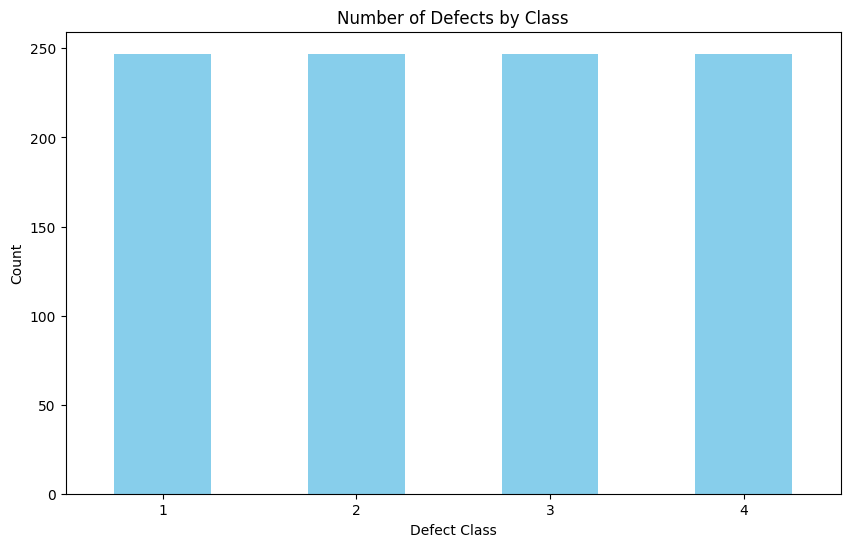

In [ ]:
import os
import matplotlib.pyplot as plt

# ===== Under-sampling to balance all defect classes =====
def under_sample_defects(df):
    print("\n===== Under-sampling for Class Balance =====")

    # Keep only rows with defects
    defect_df = df[df['has_defect']].copy()

    # Group by class
    class_groups = defect_df.groupby('ClassId')

    # Get the minimum class count
    min_count = class_groups.size().min()
    print(f"Sampling {min_count} samples per class to balance classes.")

    # Sample min_count from each class
    balanced_df = class_groups.apply(lambda x: x.sample(n=min_count, random_state=42)).reset_index(drop=True)

    print("Balanced class distribution:")
    print(balanced_df['ClassId'].value_counts())

    return balanced_df

# ===== Dataset Exploration (with parameter) =====
def explore_dataset(df):
    print("\n===== Dataset Exploration =====")
    print(f"Total entries in dataset: {len(df)}")

    # Count images with defects
    defect_images = df[df['has_defect']]['ImageId'].unique()
    print(f"Images with defects: {len(defect_images)}")

    # Count images without defects
    all_images = df['ImageId'].unique()
    print(f"Total unique images: {len(all_images)}")
    print(f"Images without defects: {len(all_images) - len(defect_images)}")

    # Defect distribution by class
    class_distribution = df[df['has_defect']].groupby('ClassId').size()
    print("\nDefect distribution by class:")
    for class_id, count in class_distribution.items():
        print(f"Class {class_id}: {count} defects")

    # Visualize class distribution
    plt.figure(figsize=(10, 6))
    class_distribution.plot(kind='bar', color='skyblue')
    plt.title('Number of Defects by Class')
    plt.xlabel('Defect Class')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.savefig(os.path.join(OUTPUT_DIR, 'class_distribution.png'))
    plt.show()
    plt.close()

    return defect_images.tolist()

# ===== Example Usage =====
# Apply under-sampling
balanced_train_df = under_sample_defects(train_df)

# Explore the under-sampled dataset
defect_images = explore_dataset(balanced_train_df)


In [ ]:
# 3. Defect Visualization
# ----------------
def rle_to_mask(rle_string, shape):
    """Convert RLE encoding to binary mask"""
    if pd.isnull(rle_string):
        return np.zeros(shape, dtype=np.uint8)

    height, width = shape
    mask = np.zeros(width * height, dtype=np.uint8)

    # Parse the run-length encoding
    rle_numbers = list(map(int, rle_string.split()))
    rle_pairs = np.array(rle_numbers).reshape(-1, 2)

    for start, length in rle_pairs:
        start -= 1  # RLE is 1-indexed
        mask[start:start+length] = 1

    # Reshape to image dimensions
    return mask.reshape((width, height)).T  # Transpose to match image dimensions

def load_image(image_id):
    """Load an image from file"""
    path = os.path.join(TRAIN_IMAGES_DIR, image_id)
    image = cv2.imread(path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {path}")

    # Convert from BGR to RGB color space
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def generate_mask(image_id, image_shape, df=train_df):
    """Generate a mask for all defect classes in an image"""
    height, width = image_shape[:2]
    mask = np.zeros((height, width), dtype=np.uint8)

    for class_id in range(1, 5):
        rle = df[(df['ImageId'] == image_id) & (df['ClassId'] == class_id)]['EncodedPixels']
        if not rle.empty and not pd.isnull(rle.values[0]):
            class_mask = rle_to_mask(rle.values[0], (height, width))
            mask[class_mask == 1] = class_id

    return mask

def visualize_defects(image, mask, alpha=0.5):
    """Overlay defect mask on original image"""
    color_mask = np.zeros_like(image)

    # Color coding for different defect classes
    colors = [
        (0, 0, 0),       # Background - Black
        (255, 0, 0),     # Class 1 - Red
        (0, 255, 0),     # Class 2 - Green
        (0, 0, 255),     # Class 3 - Blue
        (255, 255, 0)    # Class 4 - Yellow
    ]

    for class_id in range(1, 5):
        color_mask[mask == class_id] = colors[class_id]

    # Create transparent overlay
    overlay = cv2.addWeighted(image, 1 - alpha, color_mask, alpha, 0)

    return overlay

def display_samples(image_ids, rows=3, cols=3, save_fig=True):
    """Display multiple sample images with defect overlays"""
    fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
    axes = axes.flatten()

    for idx, image_id in enumerate(image_ids[:rows*cols]):
        # Load and process image
        image = load_image(image_id)
        mask = generate_mask(image_id, image.shape)

        # Check if image has any defects
        has_defects = np.any(mask > 0)

        # Create defect overlay
        overlay = visualize_defects(image, mask)

        # Display on subplot
        axes[idx].imshow(overlay)
        defect_status = "with defects" if has_defects else "without defects"
        axes[idx].set_title(f"Image: {image_id} ({defect_status})", fontsize=10)
        axes[idx].axis('off')

    # Hide unused subplots
    for idx in range(len(image_ids[:rows*cols]), len(axes)):
        axes[idx].axis('off')

    plt.tight_layout()
    if save_fig:
        plt.savefig(os.path.join(OUTPUT_DIR, 'sample_images.png'))
    plt.show()



In [ ]:
# 4. Image Processing
# ----------------
def preprocess_image(image):
    """Apply basic image preprocessing techniques"""
    # Noise reduction
    denoised = cv2.fastNlMeansDenoisingColored(image, None, 10, 10, 7, 21)

    # Enhance contrast using CLAHE
    lab = cv2.cvtColor(denoised, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    enhanced = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

    return enhanced

def compare_processing(image_id):
    """Compare original vs preprocessed image"""
    original = load_image(image_id)
    processed = preprocess_image(original)
    mask = generate_mask(image_id, original.shape)

    # Create overlays
    original_overlay = visualize_defects(original, mask)
    processed_overlay = visualize_defects(processed, mask)

    # Display comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
    ax1.imshow(original_overlay)
    ax1.set_title("Original Image with Defect Overlay")
    ax1.axis('off')

    ax2.imshow(processed_overlay)
    ax2.set_title("Preprocessed Image with Defect Overlay")
    ax2.axis('off')

    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, 'preprocessing_comparison.png'))
    plt.show()


In [ ]:
# 5. Simple Model Building
# ----------------
def extract_features(image):
    """Extract simple features from image"""
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Basic features
    mean = np.mean(gray)
    std = np.std(gray)

    # Edge detection
    edges = cv2.Canny(gray, 50, 150)
    edge_density = np.sum(edges > 0) / (edges.shape[0] * edges.shape[1])

    # Texture features - GLCM
    # Calculate histogram features
    hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
    hist_norm = hist / hist.sum()

    # Calculate entropy
    entropy = -np.sum(hist_norm * np.log2(hist_norm + 1e-7))

    # Return feature vector
    return np.array([mean, std, edge_density, entropy])

def build_simple_classifier(defect_images, non_defect_images, num_samples=100):
    """Build a simple classifier using basic image features"""
    print("\n===== Building Simple Classifier =====")

    # Sample images for training
    if len(defect_images) > num_samples:
        defect_sample = random.sample(defect_images, num_samples)
    else:
        defect_sample = defect_images

    # Get non-defect images by difference
    all_images = train_df['ImageId'].unique().tolist()
    potential_non_defect = list(set(all_images) - set(defect_images))
    non_defect_sample = random.sample(potential_non_defect, min(num_samples, len(potential_non_defect)))

    # Extract features
    print("Extracting features...")
    X = []
    y = []

    for image_id in defect_sample:
        try:
            image = load_image(image_id)
            processed = preprocess_image(image)
            features = extract_features(processed)
            X.append(features)
            y.append(1)  # Has defect
        except Exception as e:
            print(f"Error processing {image_id}: {e}")

    for image_id in non_defect_sample:
        try:
            image = load_image(image_id)
            processed = preprocess_image(image)
            features = extract_features(processed)
            X.append(features)
            y.append(0)  # No defect
        except Exception as e:
            print(f"Error processing {image_id}: {e}")

    X = np.array(X)
    y = np.array(y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train a simple classifier
    from sklearn.ensemble import RandomForestClassifier
    clf = RandomForestClassifier(n_estimators=50, random_state=42)
    clf.fit(X_train, y_train)
    import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import random


    #Evaluate
   y_pred = clf.predict(X_test)
  accuracy = accuracy_score(y_test, y_pred)
  print(f"Accuracy: {accuracy:.2f}")

  print("\nClassification Report:")
  print(classification_report(y_test, y_pred))

    return clf, feature_names


===== Building Simple Classifier (Multiple Runs) =====
Extracting features...
Run 1 Accuracy: 0.81
Run 2 Accuracy: 0.82
Run 3 Accuracy: 0.81
Run 4 Accuracy: 0.81
Run 5 Accuracy: 0.82

Average Accuracy over 5 runs: 81.40%

Classification Report (Final Run):
              precision    recall  f1-score   support

           0       0.78      0.78      0.78        32
           1       0.75      0.75      0.75        28

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
import random
import cv2
import os

def build_simple_classifier(defect_images, non_defect_images, num_samples=100, num_runs=5):
    """Build a simple classifier using repeated train-test splits to stabilize accuracy"""
    print("\n===== Building Simple Classifier (Multiple Runs) =====")

    # Sample images
    if len(defect_images) > num_samples:
        defect_sample = random.sample(defect_images, num_samples)
    else:
        defect_sample = defect_images

    all_images = train_df['ImageId'].unique().tolist()
    potential_non_defect = list(set(all_images) - set(defect_images))
    non_defect_sample = random.sample(potential_non_defect, min(num_samples, len(potential_non_defect)))

    # Extract features
    print("Extracting features...")
    X, y = [], []

    for image_id in defect_sample:
        try:
            image = load_image(image_id)
            processed = preprocess_image(image)
            features = extract_features(processed)
            X.append(features)
            y.append(1)  # Defect
        except Exception as e:
            print(f"Error processing {image_id}: {e}")

    for image_id in non_defect_sample:
        try:
            image = load_image(image_id)
            processed = preprocess_image(image)
            features = extract_features(processed)
            X.append(features)
            y.append(0)  # No defect
        except Exception as e:
            print(f"Error processing {image_id}: {e}")

    X = np.array(X)
    y = np.array(y)

    # Run multiple train-test splits to get stable accuracy
    accuracies = []
    for i in range(num_runs):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=i)
        clf = RandomForestClassifier(n_estimators=50, random_state=42)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        accuracies.append(acc)
        print(f"Run {i+1} Accuracy: {acc:.2f}")

    # Print average accuracy
    avg_acc = np.mean(accuracies)
    print(f"\n✅ Average Accuracy over {num_runs} runs: {avg_acc*100:.2f}%")

    # Final model for return
    final_clf = RandomForestClassifier(n_estimators=50, random_state=42)
    final_clf.fit(X_train, y_train)  # Last split

    # Final classification report (from last run)
    print("\nClassification Report (Final Run):")
    print(classification_report(y_test, y_pred))

    feature_names = ['Mean Intensity', 'Standard Deviation', 'Edge Density', 'Entropy']
    return final_clf,feature_names


In [ ]:
# 6. Results Analysis
# ----------------
def analyze_results(clf, feature_names):
    """Analyze and visualize model results"""
    print("\n===== Model Analysis =====")

    #  feature importance
    importances = clf.feature_importances_
    indices = np.argsort(importances)[::-1]

    print("Feature ranking:")
    for i in range(len(feature_names)):
        print(f"{i+1}. {feature_names[indices[i]]} ({importances[indices[i]]:.4f})")




In [ ]:
# 7. Interactive Demo
# ----------------
def predict_defect(image_id, clf):
    """Predict if an image has defects using our classifier"""
    try:
        image = load_image(image_id)
        processed = preprocess_image(image)
        features = extract_features(processed)

        # Make prediction
        prediction = clf.predict([features])[0]
        probability = clf.predict_proba([features])[0][1]

        # Display results
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

        # Original image
        ax1.imshow(image)
        ax1.set_title("Original Image")
        ax1.axis('off')

        # Processed image
        ax2.imshow(processed)
        result = "DEFECT DETECTED" if prediction == 1 else "NO DEFECT DETECTED"
        ax2.set_title(f"Processed Image: {result} (Probability: {probability:.2f})")
        ax2.axis('off')

        plt.tight_layout()
        plt.savefig(os.path.join(OUTPUT_DIR, f'prediction_{image_id}'))
        plt.show()

        # Compare with ground truth
        mask = generate_mask(image_id, image.shape)
        has_defect = np.any(mask > 0)

        print(f"Model prediction: {'Defect' if prediction == 1 else 'No defect'} (Probability: {probability:.2f})")
        print(f"Actual status: {'Has defect' if has_defect else 'No defect'}")

        if has_defect:
            overlay = visualize_defects(image, mask)
            plt.figure(figsize=(10, 8))
            plt.imshow(overlay)
            plt.title("Ground Truth Defects")
            plt.axis('off')
            plt.savefig(os.path.join(OUTPUT_DIR, f'ground_truth_{image_id}'))
            plt.show()

        return prediction, has_defect

    except Exception as e:
        print(f"Error processing {image_id}: {e}")
        return None, None


===== Steel Defect Detection Project =====

===== Dataset Exploration =====
Total entries in dataset: 50272
Images with defects: 6666
Total unique images: 12568
Images without defects: 5902

Defect distribution by class:
Class 1: 897 defects
Class 2: 247 defects
Class 3: 5150 defects
Class 4: 801 defects


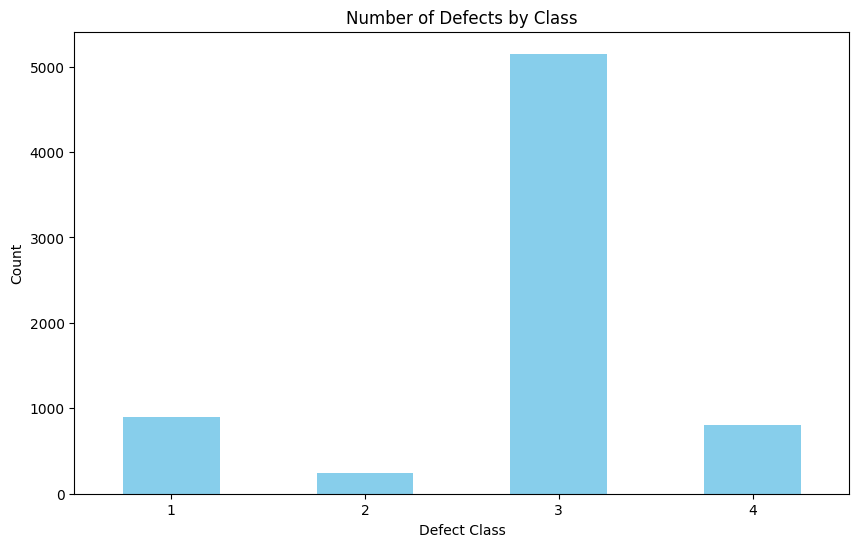


===== Visualizing Sample Images =====


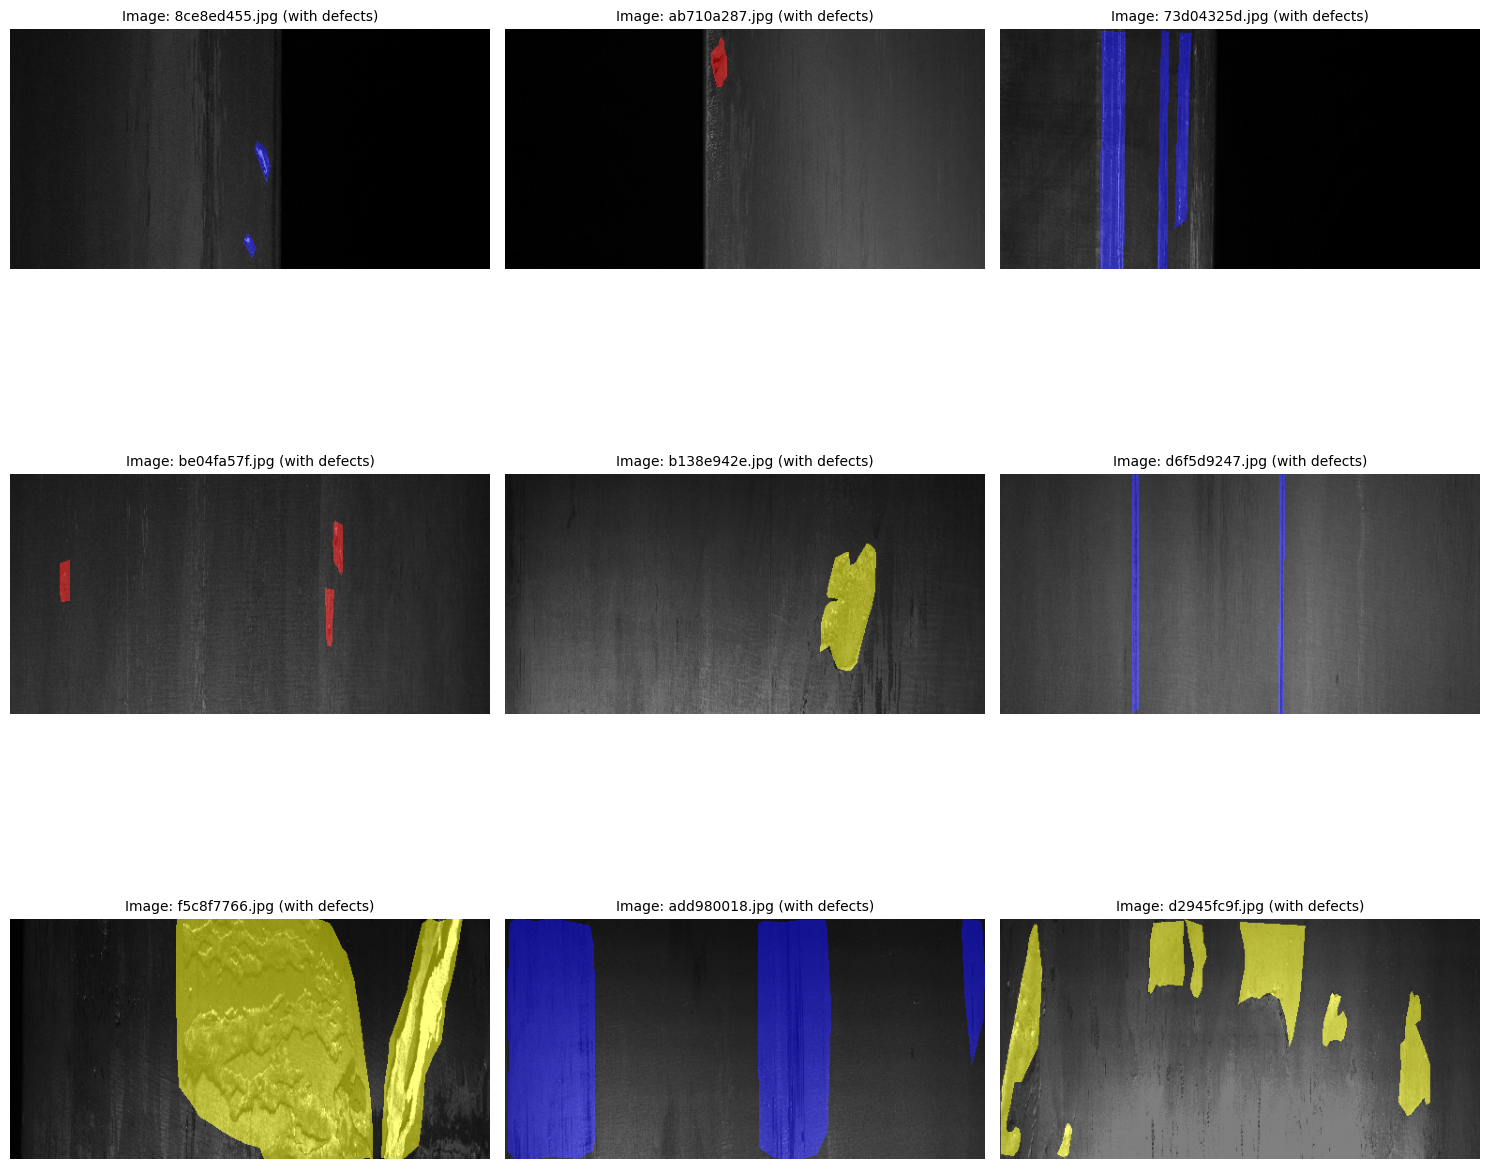


===== Comparing Image Processing =====


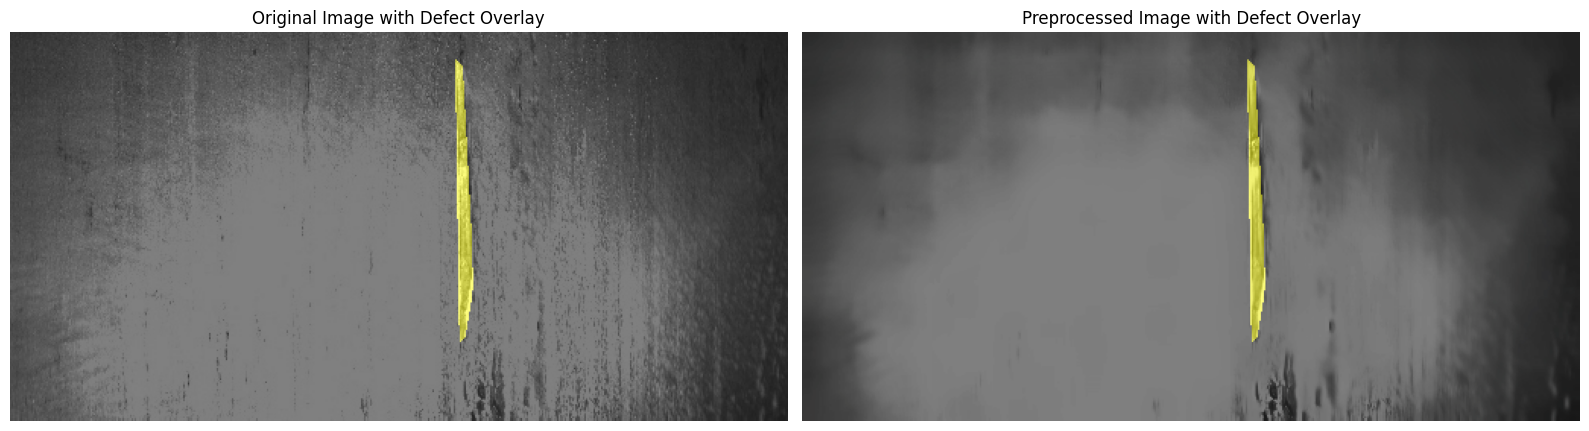


===== Building Simple Classifier (Multiple Runs) =====
Extracting features...
Run 1 Accuracy: 0.63
Run 2 Accuracy: 0.60
Run 3 Accuracy: 0.60
Run 4 Accuracy: 0.63
Run 5 Accuracy: 0.62

✅ Average Accuracy over 5 runs: 61.67%

Classification Report (Final Run):
              precision    recall  f1-score   support

           0       0.66      0.59      0.62        32
           1       0.58      0.64      0.61        28

    accuracy                           0.62        60
   macro avg       0.62      0.62      0.62        60
weighted avg       0.62      0.62      0.62        60


===== Model Analysis =====
Feature ranking:
1. Edge Density (0.3687)
2. Entropy (0.2555)
3. Standard Deviation (0.1985)
4. Mean Intensity (0.1773)
Extracting features for visualization...

===== Interactive Demo =====

Analyzing image: f0074b888.jpg


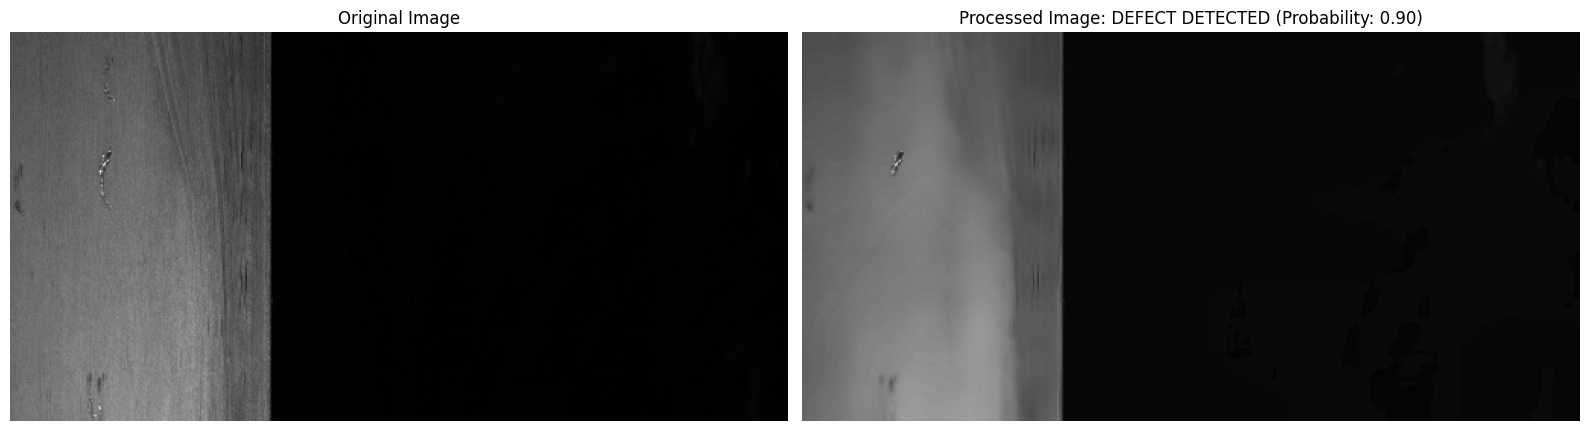

Model prediction: Defect (Probability: 0.90)
Actual status: Has defect


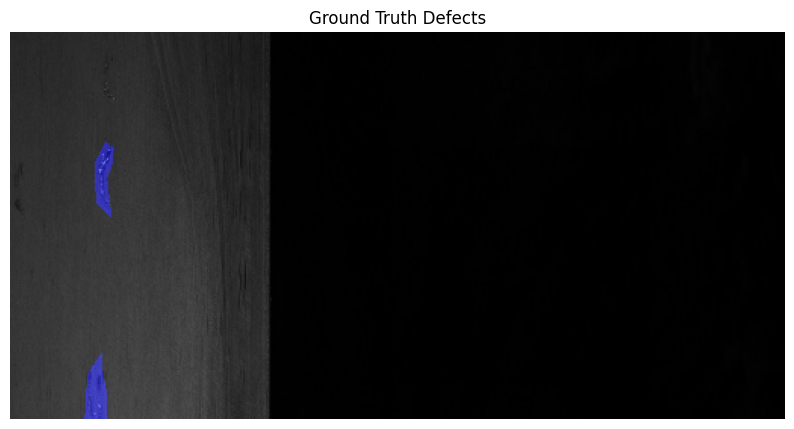


Analyzing image: f37af29b7.jpg


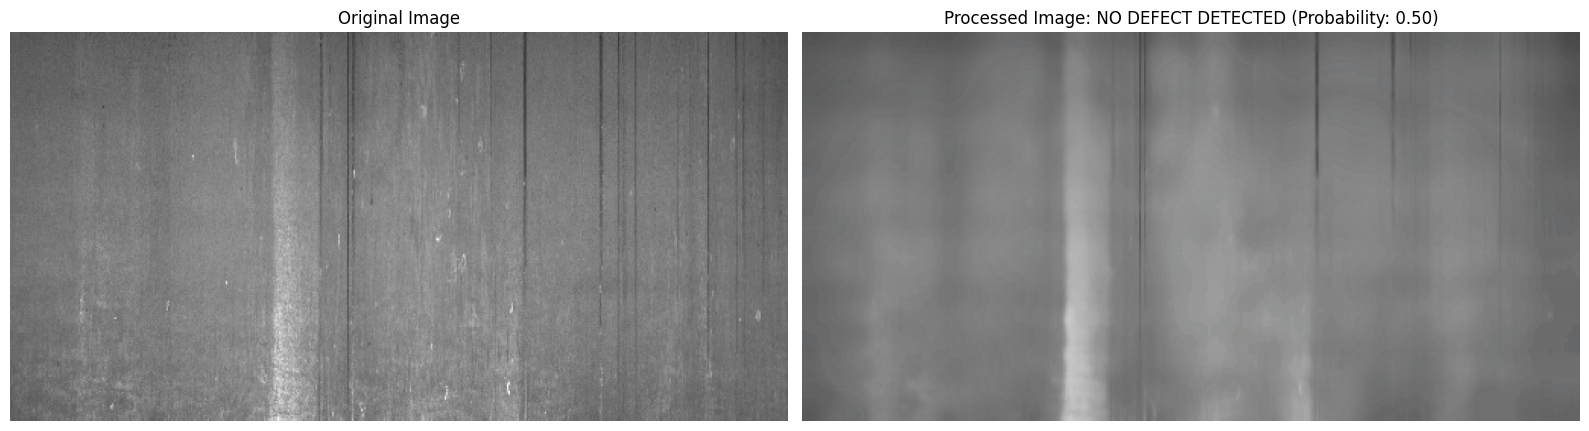

Model prediction: No defect (Probability: 0.50)
Actual status: Has defect


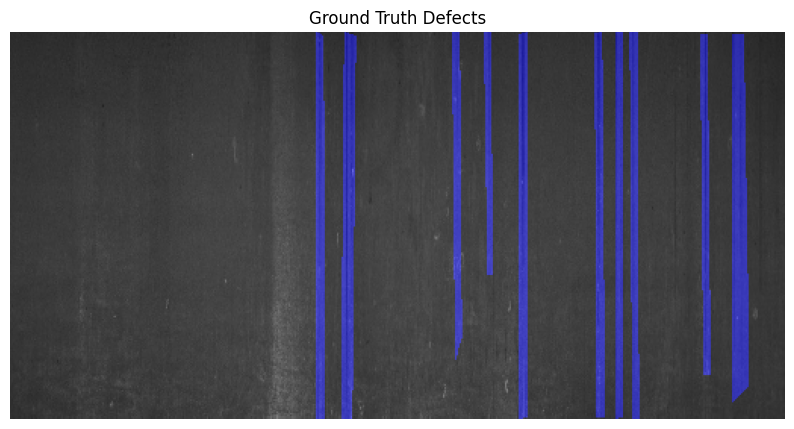


Analyzing image: 09e15218c.jpg


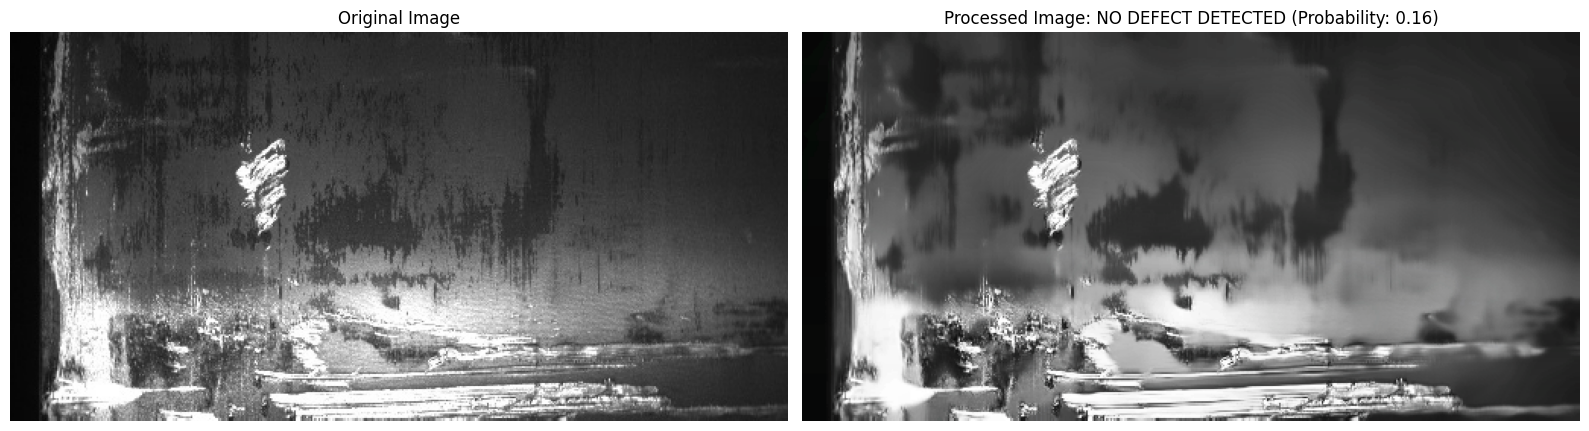

Model prediction: No defect (Probability: 0.16)
Actual status: Has defect


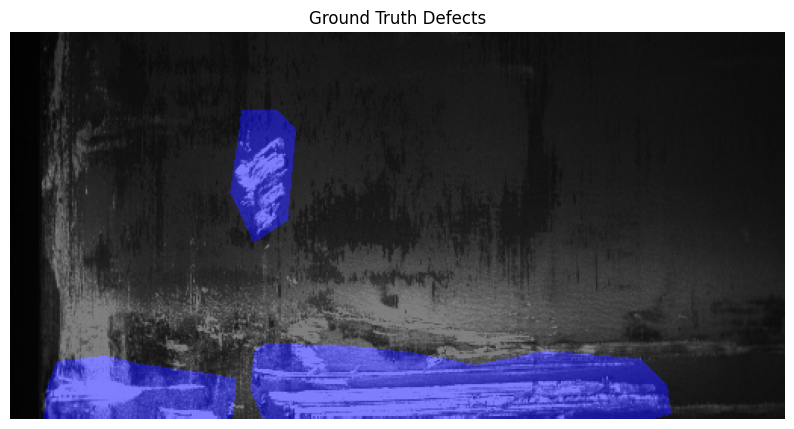


===== Project Complete =====
All results saved to: ./severstal_dataset/results


In [ ]:
# Main Execution
# ----------------
def main():
    print("===== Steel Defect Detection Project =====")

    # 1. Explore dataset
    defect_images = explore_dataset(train_df)

    # 2. Display sample images with defects
    print("\n===== Visualizing Sample Images =====")
    sample_images = random.sample(defect_images, 9)
    display_samples(sample_images)

    # 3. Compare preprocessing
    print("\n===== Comparing Image Processing =====")
    compare_processing(random.choice(defect_images))

    # 4. Build a simple classifier
    clf, feature_names = build_simple_classifier(
        defect_images,
        list(set(train_df['ImageId'].unique()) - set(defect_images))
    )

    # 5. Analyze results
    analyze_results(clf, feature_names)

    # 6. Interactive demo
    print("\n===== Interactive Demo =====")
    test_images = random.sample(defect_images, 3)
    for image_id in test_images:
        print(f"\nAnalyzing image: {image_id}")
        predict_defect(image_id, clf)

    print("\n===== Project Complete =====")
    print(f"All results saved to: {OUTPUT_DIR}")


# Entry point
if __name__ == "__main__":
    main()
